In [1]:
# Imports.
import matplotlib.pyplot as plt
import requests
import pandas as pd
import numpy as np
import json
import geopandas as gpd
from shapely.geometry import Point
from census import Census
from us import states

## Analyzing Aggravated Burglaries in Davidson County

1. A dataset containing details about Metro Nashville Police Department reported incidents is available at https://data.nashville.gov/Police/Metro-Nashville-Police-Department-Incidents/2u6v-ujjs. Make use of the API to find all aggravated burglary incidents that were reported during the six month period from January 1, 2021 through June 30, 2021.

In [2]:
# Question 1

#Read in JSON file using API with selection of aggravated burglary incidents between floating timestamp datatype values.
response = requests.get('https://data.nashville.gov/resource/2u6v-ujjs.json?offense_description=BURGLARY- AGGRAVATED&\
$where=incident_reported between "2021-01-01T00:00:00.000" and "2021-07-01T00:00:00.000"')
burglaries = (
    pd.read_json(response.text)
    .drop_duplicates(subset = "incident_number")
)

#Create GeoDataFrame using longitude and latitude in burglaries dataframe.
geometry = [Point(xy) for xy in zip(burglaries['longitude'], burglaries['latitude'])]
burglaries = burglaries.drop(['longitude', 'latitude'], axis = 1)
geo_burglaries = gpd.GeoDataFrame(burglaries, crs = "EPSG:4269", geometry = geometry)

2. Download the 2019 census tract shapefiles for Tennessee from https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2019.html. (The FIPS code for Tennessee is 47). Perform a spatial join to determine the census tract in which each burglary incident occurred. Which census tract had the highest number of burglaries? Warning - each incident can appear multiple times if there are multiple victims, so be sure that you aren't double-counting any incidents.

In [3]:
# Question 2

# Use Geopandas to read in census tract files
census_tracts = gpd.read_file("../data/tl_2019_47_tract.shx")
geo_burg_census = (
    gpd.sjoin(geo_burglaries, census_tracts, how = "inner", op = "within")
    .rename(columns = {'NAMELSAD':'Census Tract'})
)

# Census Tract 163 is where the most incidents have occurred. Check answer against others from your team.
# Also create dataframe for number of burglaries per census tract in Davidson County, TN for later question.
burglaries_per_1000 = (
    geo_burg_census['Census Tract'].value_counts().reset_index()
    .rename(columns = {'index':'Census Tract', 'Census Tract':'Burglary Number'})
)
burglaries_per_1000[burglaries_per_1000['Burglary Number'] == burglaries_per_1000['Burglary Number'].max()]

,Census Tract,Burglary Number
0,Census Tract 163,52


3. For this part, you'll need to request a census API key. Using the 2019 American Community Survey API, obtain, for each census tract, the population (B01001_001E in the detailed tables) and the median income (S1901_C01_012E in the subject tables). Hint: Tennessee's FIPS code is 47 and Davidson County's FIPS code is 37. Merge this new data with the burglaries data above.

In [4]:
# Question 3

# Load census API key.
with open('../data/census.json') as fi:
    credentials = json.load(fi)
api_key = credentials['api_key']
c = Census(api_key)

# Get requests using census package.
davidson_pop = c.acs5.state_county_tract(['NAME', 'B01001_001E'], '47', '037', Census.ALL, year = 2019)
davidson_inc = c.acs5st.state_county_tract(['NAME', 'S1901_C01_012E'], '47', '037', Census.ALL, year = 2019)

# Create GeoDataFrames, clean them up a little and merge them into geo_burg_census with an attribute join.
def convert_clean_and_merge(acquirer, *args):
    return_list = []
    for df in args:
        df = pd.DataFrame(df)
        df["Census Tract"] = df['NAME'].str.split(',', expand = True)[0]
        df = (
            df.rename(columns = {'B01001_001E':'Total Population',\
                                      'S1901_C01_012E':'Median Income'})
                    .drop(columns = ['NAME', 'state', 'county', 'tract'])
        )
        acquirer = acquirer.merge(df)
    return acquirer

geo_burg_census = convert_clean_and_merge(geo_burg_census, davidson_pop, davidson_inc)

4. Create a choropleth showing the number of burglaries per 1000 residents for each census tract.

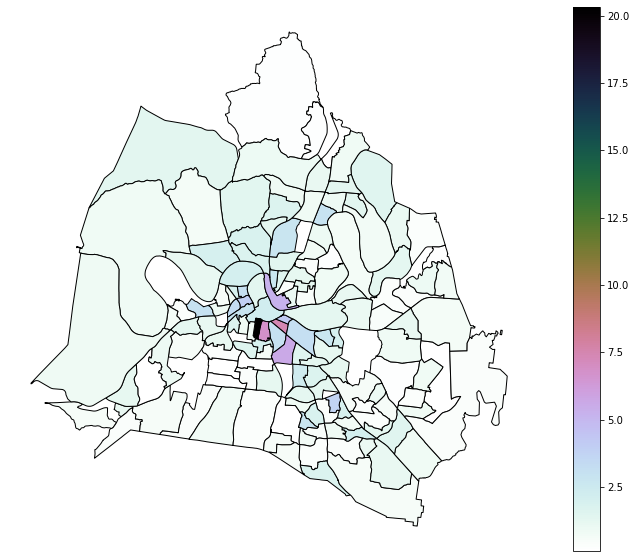

In [5]:
# Question 4

# Consider condensing code in this section.
# Subset geo_burg_census to tracts and population.
only_tracts_population = (
    geo_burg_census[['Census Tract', 'Total Population']]
    .drop_duplicates(subset = {'Census Tract'})
)

# Subset dataframe of census tract locations into just Davidson.
only_davidson_census_tracts = census_tracts.loc[census_tracts['COUNTYFP'].isin(['037'])]

# Merge that dataframe with burglaries_per_1000.
merged_burglaries_per_1000 = pd.merge(burglaries_per_1000, only_tracts_population, how = "inner", on = "Census Tract")

# Create a column for burglaries per 1,000 people.
merged_burglaries_per_1000["Burglaries per 1,000 People"] = (
    merged_burglaries_per_1000["Burglary Number"]/merged_burglaries_per_1000["Total Population"] * 1000
)

# Merge with merged_burglaries_per_1000.
merged_burglaries_per_1000 = (
    pd.merge(only_davidson_census_tracts, merged_burglaries_per_1000, left_on = 'NAMELSAD', right_on = 'Census Tract')
)

# Subset merged_burglaries_per_1000 to only relevant columns
merged_burglaries_per_1000 = (
    merged_burglaries_per_1000[['geometry','Census Tract','Burglary Number',\
                                'Total Population','Burglaries per 1,000 People']]
)

# Remove potentially hidden infinite or NaN values.
merged_burglaries_per_1000.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_burglaries_per_1000.dropna(subset = ['Burglaries per 1,000 People'])

# Plot choropleth!
fig, ax = plt.subplots(figsize = (15, 10))
merged_burglaries_per_1000.plot(column = 'Burglaries per 1,000 People', 
                                cmap = 'cubehelix_r', 
                                edgecolor = 'black', 
                                ax = ax,
                                legend = True)
ax.axis('off');

5. Finally, we'll build some statistical models to see how well we can explain the number of aggravated burglaries using the median income of each census tract. For this, we'll be using the Generalized Linear Models module of the statsmodels library.

a. Build a "base model" - a Poisson regression model with just an intercept term with target variable the rate of burglaries per census tract. (Offset using the [log of the] population so that we are looking at the rate of burglaries per population instead of the number of burglaries.)

b. Now, build a Poisson regression model with target variable the rate of burglaries and predictor variable the median income. (Don't forget to offset by the population).

c. Finally, try out a negative binomial model. To get started with a negative binomial model, you can check out this tutorial.

d. How do your models compare? Hint: the fit models have an AIC attribute.

Prepare a short presentation (<10 minutes) of your findings.